### Задание №1 [SQL](#sql)

    
### Задание №2 [Python - Сегментация клиентов](#python)

In [1]:
import pandas as pd
import numpy as np
import sqlite3

<a name="sql"></a>
### I. SQL

In [2]:
conn = sqlite3.connect(':memory:')

In [3]:
customers = pd.read_excel('E:\Downloads\Data files\Customer_info.xlsx')
customers.head()

,Id_client,Total_amount,Gender,Age,Count_city,Response_communcation,Communication_3month,Tenure
0,16052,1636.81,F,65.0,1,1,1,5
1,25027,4539.09,M,29.0,1,1,1,10
2,25659,6342.11,F,44.0,1,0,1,10
3,33297,9755.31,F,32.0,1,0,1,12
4,38750,5682.20,F,53.0,1,1,1,11


In [4]:
customers.to_sql(name='customers', con=conn)

In [5]:
query = "select * from customers;"
conn.execute(query).fetchmany(10)

[(0, 16052, 1636.81, 'F', 65.0, 1, 1, 1, 5),
 (1, 25027, 4539.09, 'M', 29.0, 1, 1, 1, 10),
 (2, 25659, 6342.11, 'F', 44.0, 1, 0, 1, 10),
 (3, 33297, 9755.31, 'F', 32.0, 1, 0, 1, 12),
 (4, 38750, 5682.2, 'F', 53.0, 1, 1, 1, 11),
 (5, 43063, 2838.66, 'M', 28.0, 1, 0, 1, 9),
 (6, 56311, 2434.96, 'F', 48.0, 1, 1, 1, 11),
 (7, 61721, 7424.61, 'F', 21.0, 1, 0, 1, 10),
 (8, 104027, 6652.86, 'F', 25.0, 1, 1, 1, 10),
 (9, 112005, 1743.74, 'F', 40.0, 1, 1, 1, 6)]

In [6]:
transactions = pd.read_excel('E:\Downloads\Data files\Transactions_info.xlsx')
transactions.head()

,date_new,Id_check,ID_client,Count_products,Sum_payment
0,2016-03-01,2271145,104027,2.034,23.31
1,2016-03-01,2271145,104027,1.000,31.75
2,2016-03-01,2271145,104027,1.000,6.80
3,2016-03-01,2271145,104027,1.000,6.24
4,2016-03-01,2271145,104027,1.000,36.98


In [7]:
transactions.to_sql(name='transactions', con=conn)

In [8]:
query = "select * from transactions;"
conn.execute(query).fetchmany(10)

[(0, '2016-03-01 00:00:00', 2271145, 104027, 2.034, 23.31),
 (1, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 31.75),
 (2, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 6.8),
 (3, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 6.24),
 (4, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 36.98),
 (5, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 10.93),
 (6, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 60.96),
 (7, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 72.17),
 (8, '2016-03-01 00:00:00', 2271145, 104027, 1.0, 60.96),
 (9, '2015-07-01 00:00:00', 1771932, 112005, 1.0, 2.15)]

#### 1. Вывести список клиентов с непрерывной историей за год, средний чек за период, среднюю сумму покупок за месяц, количество всех операций по клиенту за период

In [9]:
query = """

with per_month as (
    select ID_client,
        date,
        round(avg(total_products),2) avg_products,
        round((sum(total_sum)/count(Id_check)),2) avg_order_value,
        count(Id_check) month_purchases
    from (
        select ID_client,
            Id_check,
            date(date_new) date,
            round(sum(Count_products),2) total_products,
            round(sum(Sum_payment),2) total_sum
        from transactions
        group by 1,2,3
        order by 3)
    group by 1, 2
    order by 1,2)

select strftime("%Y", date) date,
ID_client,
round(avg(avg_products),2) avg_products,
round(avg(avg_order_value),2) avg_order_value,
sum(month_purchases) total_purchases
from per_month
group by 1,2;"""
cnames = conn.execute(query).description
print([i[0] for i in cnames])
conn.execute(query).fetchmany(10)

['date', 'ID_client', 'avg_products', 'avg_order_value', 'total_purchases']


[('2015', 16052, 17.41, 81.82, 3182),
 ('2015', 33297, 14.62, 101.15, 4),
 ('2015', 38750, 2.0, 74.64, 1),
 ('2015', 43063, 18.5, 194.23, 5),
 ('2015', 56311, 7.61, 146.7, 1),
 ('2015', 112005, 21.27, 75.02, 12),
 ('2015', 114395, 13.66, 95.97, 20),
 ('2015', 114438, 4.0, 50.28, 1),
 ('2015', 133752, 16.11, 111.75, 9),
 ('2015', 138705, 16.61, 69.52, 9)]

#### 2. Вывести помесячную информацию: средняя сумма чека в месяц, среднее количество операций в месяц, среднее количество клиентов, которые совершали операции; долю от общего количества операций за год и долю в месяц от общей суммы операций

In [10]:
query = """

with per_month as (
    select 
    case 
        when strftime("%Y", date) = '2015' THEN 2015 
        else 2016
    end year,
    ID_client,
        date,
        round(avg(total_products),2) avg_products,
        round((sum(total_sum)/count(Id_check)),2) avg_order_value,
        count(Id_check) month_purchases
    from (
        select ID_client,
            Id_check,
            date(date_new) date,
            round(sum(Count_products),2) total_products,
            round(sum(Sum_payment),2) total_sum
        from transactions
        group by 1,2,3
        order by 3)
    group by 2, 3
    order by 2,3)
    
select date,
round(avg(avg_order_value),2) avg_order_value,
sum(month_purchases) month_purchases,
count(ID_client) month_clients,
case
    when year = 2015
    then round((sum(month_purchases)* 100)/cast((select sum(month_purchases) from per_month where year = 2015)as float),2)||'%'
    when year = 2016
    then round((sum(month_purchases)* 100)/cast((select sum(month_purchases) from per_month where year = 2016)as float),2)||'%'        
end as purchases_mnth_share
from per_month
group by 1;"""
cnames = conn.execute(query).description
print([i[0] for i in cnames])
conn.execute(query).fetchmany(10)

['date', 'avg_order_value', 'month_purchases', 'month_clients', 'purchases_mnth_share']


[('2015-06-01', 97.67, 316, 224, '1.78%'),
 ('2015-07-01', 93.6, 2929, 939, '16.48%'),
 ('2015-08-01', 93.1, 2862, 907, '16.11%'),
 ('2015-09-01', 94.77, 2794, 901, '15.72%'),
 ('2015-10-01', 95.27, 2936, 967, '16.52%'),
 ('2015-11-01', 90.64, 2794, 918, '15.72%'),
 ('2015-12-01', 93.58, 3139, 1032, '17.66%'),
 ('2016-01-01', 93.04, 3052, 991, '12.61%'),
 ('2016-02-01', 111.7, 4681, 1254, '19.35%'),
 ('2016-03-01', 99.7, 4467, 1181, '18.46%')]

#### 3. Вывести возрастные группы клиентов с шагом 10 лет и отдельно клиентов, у которых нет данной информации с параметрами сумма и количество операций за весь период, и поквартально, средние показатели и %.

In [11]:
query = """

select
case
    when date between '2015-01-01' and '2015-03-01' then 'Q1 2015'
    when date between '2015-04-01' and '2015-06-01' then 'Q2 2015'
    when date between '2015-07-01' and '2015-09-01' then 'Q3 2015'
    when date between '2015-10-01' and '2015-12-01' then 'Q4 2015'
    when date between '2016-01-01' and '2016-03-01' then 'Q1 2016'
    when date between '2016-04-01' and '2016-06-01' then 'Q2 2016'
    when date between '2016-07-01' and '2016-09-01' then 'Q3 2016'
    else 'Unknown'
end quarter,
case
    when age <= 10 then '0-10'
    when age between 11 and 20 then '11-20'
    when age between 21 and 30 then '21-30'
    when age between 31 and 40 then '31-40'
    when age between 41 and 50 then '41-50'
    when age between 51 and 60 then '51-60'
    when age between 61 and 70 then '61-70'
    when age between 71 and 80 then '71-80'
    when age between 81 and 90 then '81-90'
    when age between 91 and 100 then '91-100'
    when age > 100 then '100+'
    else 'others'
END ages,
round(sum(total_sum),2) month_order_sum,
count(Id_check) month_order_value,
round(avg(total_sum),2) avg_order_sum,
round(avg(total_products),2) avg_order_value
from (select t.ID_client id_client,
        c.Gender gender,
        c.Age age,
        t.Id_check id_check,
        date(date_new) date,
        round(sum(Count_products),2) total_products,
        round(sum(Sum_payment),2) total_sum
    from transactions t
    left join customers c
    on t.ID_client=c.Id_client
    group by 1, 4,5
    order by 5)
group by ages, quarter
order by quarter, ages;"""
cnames = conn.execute(query).description
print([i[0] for i in cnames])
conn.execute(query).fetchmany(50)

['quarter', 'ages', 'month_order_sum', 'month_order_value', 'avg_order_sum', 'avg_order_value']


[('Q1 2016', '0-10', 4471.2, 36, 124.2, 14.26),
 ('Q1 2016', '11-20', 54165.2, 521, 103.96, 13.06),
 ('Q1 2016', '21-30', 246322.91, 2388, 103.15, 13.42),
 ('Q1 2016', '31-40', 228806.47, 2350, 97.36, 12.41),
 ('Q1 2016', '41-50', 160517.11, 1614, 99.45, 12.12),
 ('Q1 2016', '51-60', 161326.87, 1537, 104.96, 13.13),
 ('Q1 2016', '61-70', 273848.68, 3204, 85.47, 13.02),
 ('Q1 2016', '71-80', 33845.72, 322, 105.11, 13.7),
 ('Q1 2016', '81-90', 2274.26, 24, 94.76, 10.24),
 ('Q1 2016', 'others', 20265.34, 204, 99.34, 12.65),
 ('Q2 2015', '0-10', 88.11, 1, 88.11, 7.4),
 ('Q2 2015', '11-20', 949.12, 9, 105.46, 15.02),
 ('Q2 2015', '21-30', 5955.0, 61, 97.62, 13.4),
 ('Q2 2015', '31-40', 5730.81, 58, 98.81, 12.91),
 ('Q2 2015', '41-50', 4784.33, 46, 104.01, 13.65),
 ('Q2 2015', '51-60', 2880.24, 34, 84.71, 11.2),
 ('Q2 2015', '61-70', 7767.19, 90, 86.3, 11.87),
 ('Q2 2015', '71-80', 1435.76, 12, 119.65, 14.4),
 ('Q2 2015', '81-90', 100.82, 1, 100.82, 16.02),
 ('Q2 2015', 'others', 409.78, 4, 

<a name="python"></a>
### II. Python - Сегментация клиентов

In [12]:
df = pd.read_excel('E:\\Downloads\\Data files\\for_clustering.xlsx')
df.shape

(27508, 45)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id_client                 27508 non-null  int64  
 1   InWeek_amount             27508 non-null  float64
 2   InWeek_SKU                27508 non-null  int64  
 3   Checkinmonth_average      27508 non-null  int64  
 4   Checkamount_mean          27508 non-null  float64
 5   Count_transac             27508 non-null  int64  
 6   Total_amount              27508 non-null  float64
 7   Total_SKU_qnt             27508 non-null  int64  
 8   Count_departments         27508 non-null  int64  
 9   Count_shop                27508 non-null  int64  
 10  Count_city                27508 non-null  int64  
 11  Tenure                    27508 non-null  int64  
 12  SKU_meanbytransac         27508 non-null  int64  
 13  Amount_last6mnth          27508 non-null  float64
 14  Check_

In [14]:
pd.options.display.max_columns = None

In [15]:
df.head()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Age_group,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,1,12,3,1295.44,22,10.360064,F,37.0,35-45,11,3,175,2747.71,0.221616,278,3490.27,0.281507,420,4096.35,0.330391,161,1059.810,0.085479,80,1004.370,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,1,10,2,1835.23,17,12.088369,F,29.0,25-35,11,2,199,4097.59,0.316181,279,4027.09,0.310741,407,3303.69,0.254921,93,1054.805,0.081391,46,476.475,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,1,6,4,586.79,7,15.591491,F,33.0,25-35,29,8,18,121.36,0.040946,62,2013.35,0.679295,39,159.50,0.053815,34,334.830,0.112970,17,334.840,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,1,12,1,1374.17,36,7.703276,F,50.0,45-55,11,0,798,5176.77,0.263096,500,5094.25,0.258902,995,7777.19,0.395256,129,1088.880,0.055340,64,539.250,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,1,5,4,1469.43,11,9.278015,F,33.0,25-35,14,8,59,639.32,0.257558,73,807.58,0.325343,90,264.95,0.106738,22,664.180,0.267573,11,106.210,0.042788,1,1,22,3,557.97,1,1,1,1


In [16]:
df.describe()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Age,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27356.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000,27508.000000
mean,210314.227534,314.792325,31.457212,2.565363,159.516226,82.467500,9595.761182,764.242293,26.742911,3.858550,1.079613,9.872401,4.235095,1137.986565,8.016613,13.233163,43.024492,16.040461,5.291915,153.123346,2212.690888,0.230468,206.294569,3193.837092,0.326968,311.619056,2905.685814,0.307797,62.303475,725.944267,0.076154,30.901847,557.603120,0.058614,0.999964,0.547368,40.344009,8.395158,936.135833,0.998073,0.920823,2.002836,2.002836
std,121828.905739,144.491147,11.379580,1.205160,111.533576,63.241479,4715.290935,451.728512,4.038126,2.757808,0.295729,2.120812,2.899742,490.755079,6.947595,4.984101,14.269920,6.420182,4.548674,109.706269,1386.636725,0.085635,137.099159,2019.471803,0.114520,246.678994,1844.887500,0.123203,49.729726,586.075099,0.048594,24.865939,557.239232,0.048882,0.006029,0.497760,23.765321,7.217166,590.934045,0.043853,0.270020,0.776181,0.776181
min,5743.000000,34.474000,2.000000,2.000000,10.239800,4.000000,739.360000,33.000000,7.000000,1.000000,1.000000,2.000000,0.000000,549.030000,0.000000,2.042535,0.000000,11.000000,0.000000,1.000000,9.270000,0.002708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,105405.500000,213.042000,23.000000,2.000000,85.728675,39.000000,5897.177500,433.000000,24.000000,2.000000,1.000000,8.000000,2.000000,747.505000,3.000000,9.903953,32.000000,12.000000,2.000000,76.000000,1192.252500,0.171995,105.000000,1676.410000,0.248302,142.000000,1581.217500,0.221140,29.000000,303.958750,0.041349,14.000000,168.867500,0.022734,1.000000,0.000000,22.000000,3.000000,446.880000,1.000000,1.000000,1.000000,1.000000
50%,211786.000000,289.220350,31.000000,2.000000,128.752500,66.000000,8820.700000,674.000000,27.000000,3.000000,1.000000,10.000000,4.000000,1000.135000,6.000000,12.426685,41.000000,13.000000,4.000000,127.000000,1926.945000,0.223681,177.000000,2771.710000,0.319790,246.000000,2499.825000,0.291659,50.000000,570.345000,0.067024,25.000000,390.972500,0.047616,1.000000,1.000000,37.000000,6.000000,825.895000,1.000000,1.000000,2.000000,2.000000
75%,309746.250000,385.379300,41.000000,2.000000,199.252325,108.000000,12631.300000,1003.000000,30.000000,5.000000,1.000000,12.000000,6.000000,1411.710000,11.000000,15.572424,54.000000,18.000000,7.000000,200.000000,2940.015000,0.279677,276.000000,4304.200000,0.397748,412.000000,3770.692500,0.376667,82.000000,979.432500,0.100419,41.000000,762.786250,0.081647,1.000000,1.000000,55.000000,11.000000,1329.787500,1.000000,1.000000,3.000000,3.000000
max,830188.000000,2180.013700,51.000000,20.000000,1326.115700,990.000000,22748.390000,5058.000000,38.0

In [17]:
df.isnull().sum()

Id_client                     0
InWeek_amount                 0
InWeek_SKU                    0
Checkinmonth_average          0
Checkamount_mean              0
Count_transac                 0
Total_amount                  0
Total_SKU_qnt                 0
Count_departments             0
Count_shop                    0
Count_city                    0
Tenure                        0
SKU_meanbytransac             0
Amount_last6mnth              0
Check_qntlast6mnth            0
SKU_price_mean                0
Gender                      241
Age                         152
Age_group                   152
Interval_visit                0
Days_pastvisit                0
Cat_householdchem_qnt         0
Cat_householdchem_amount      0
Cat_householdchem_share       0
Cat_careproducts_qnt          0
Cat_careproducts_amount       0
Cat_careproducts_share        0
Cat_toiletries_qnt            0
Cat_toiletries_amount         0
Cat_toiletries_share          0
Cat_healthwellnes_qnt         0
Cat_heal

In [18]:
df.Gender = df.Gender.fillna('N/A')

In [19]:
df.Age = df.Age.fillna('N/A')

In [20]:
df.Age_group = df.Age_group.fillna('N/A')

In [21]:
df.isnull().sum()

Id_client                   0
InWeek_amount               0
InWeek_SKU                  0
Checkinmonth_average        0
Checkamount_mean            0
Count_transac               0
Total_amount                0
Total_SKU_qnt               0
Count_departments           0
Count_shop                  0
Count_city                  0
Tenure                      0
SKU_meanbytransac           0
Amount_last6mnth            0
Check_qntlast6mnth          0
SKU_price_mean              0
Gender                      0
Age                         0
Age_group                   0
Interval_visit              0
Days_pastvisit              0
Cat_householdchem_qnt       0
Cat_householdchem_amount    0
Cat_householdchem_share     0
Cat_careproducts_qnt        0
Cat_careproducts_amount     0
Cat_careproducts_share      0
Cat_toiletries_qnt          0
Cat_toiletries_amount       0
Cat_toiletries_share        0
Cat_healthwellnes_qnt       0
Cat_healthwellnes_amount    0
Cat_healthwellnes_share     0
Cat_babypr

In [22]:
df.head()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Age_group,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,1,12,3,1295.44,22,10.360064,F,37,35-45,11,3,175,2747.71,0.221616,278,3490.27,0.281507,420,4096.35,0.330391,161,1059.810,0.085479,80,1004.370,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,1,10,2,1835.23,17,12.088369,F,29,25-35,11,2,199,4097.59,0.316181,279,4027.09,0.310741,407,3303.69,0.254921,93,1054.805,0.081391,46,476.475,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,1,6,4,586.79,7,15.591491,F,33,25-35,29,8,18,121.36,0.040946,62,2013.35,0.679295,39,159.50,0.053815,34,334.830,0.112970,17,334.840,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,1,12,1,1374.17,36,7.703276,F,50,45-55,11,0,798,5176.77,0.263096,500,5094.25,0.258902,995,7777.19,0.395256,129,1088.880,0.055340,64,539.250,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,1,5,4,1469.43,11,9.278015,F,33,25-35,14,8,59,639.32,0.257558,73,807.58,0.325343,90,264.95,0.106738,22,664.180,0.267573,11,106.210,0.042788,1,1,22,3,557.97,1,1,1,1


In [23]:
df.Age_group.value_counts()

25-35    7132
35-45    6889
45-55    4948
55-65    4116
65+      2355
0-25     1916
N/A       152
Name: Age_group, dtype: int64

In [24]:
df_tree = df.groupby('Age_group').size().reset_index(name='counts')
df_tree

,Age_group,counts
0,0-25,1916
1,25-35,7132
2,35-45,6889
3,45-55,4948
4,55-65,4116
5,65+,2355
6,N/A,152


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [26]:
labels = df_tree.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df_tree['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

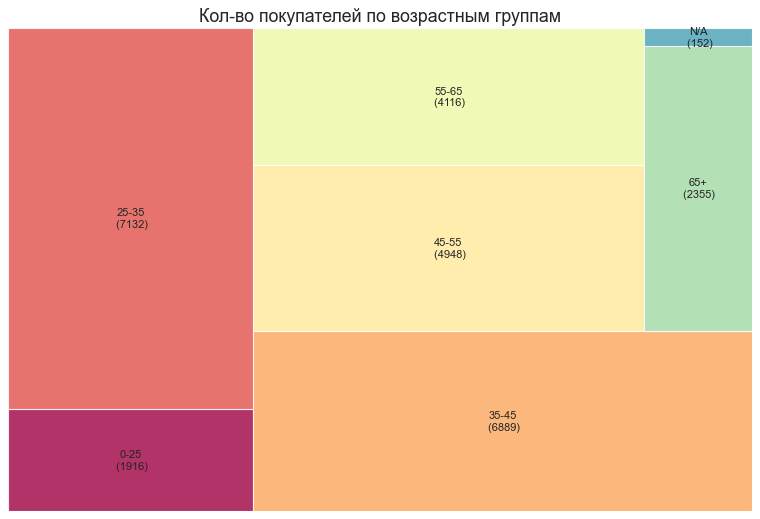

In [27]:
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

plt.title('Кол-во покупателей по возрастным группам')
plt.axis('off')
plt.show()

In [28]:
df.head()

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,Tenure,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,SKU_price_mean,Gender,Age,Age_group,Interval_visit,Days_pastvisit,Cat_householdchem_qnt,Cat_householdchem_amount,Cat_householdchem_share,Cat_careproducts_qnt,Cat_careproducts_amount,Cat_careproducts_share,Cat_toiletries_qnt,Cat_toiletries_amount,Cat_toiletries_share,Cat_healthwellnes_qnt,Cat_healthwellnes_amount,Cat_healthwellnes_share,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,1,12,3,1295.44,22,10.360064,F,37,35-45,11,3,175,2747.71,0.221616,278,3490.27,0.281507,420,4096.35,0.330391,161,1059.810,0.085479,80,1004.370,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,1,10,2,1835.23,17,12.088369,F,29,25-35,11,2,199,4097.59,0.316181,279,4027.09,0.310741,407,3303.69,0.254921,93,1054.805,0.081391,46,476.475,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,1,6,4,586.79,7,15.591491,F,33,25-35,29,8,18,121.36,0.040946,62,2013.35,0.679295,39,159.50,0.053815,34,334.830,0.112970,17,334.840,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,1,12,1,1374.17,36,7.703276,F,50,45-55,11,0,798,5176.77,0.263096,500,5094.25,0.258902,995,7777.19,0.395256,129,1088.880,0.055340,64,539.250,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,1,5,4,1469.43,11,9.278015,F,33,25-35,14,8,59,639.32,0.257558,73,807.58,0.325343,90,264.95,0.106738,22,664.180,0.267573,11,106.210,0.042788,1,1,22,3,557.97,1,1,1,1


In [29]:
len(df.Id_client.unique())

27508

In [30]:
cols=['Id_client','Age_group','Total_amount','Cat_householdchem_amount','Cat_careproducts_amount','Cat_toiletries_amount','Cat_healthwellnes_amount','Cat_babyprod_amount']
df_raw = df[cols]
df_raw.head()

,Id_client,Age_group,Total_amount,Cat_householdchem_amount,Cat_careproducts_amount,Cat_toiletries_amount,Cat_healthwellnes_amount,Cat_babyprod_amount
0,5743,35-45,12398.51,2747.71,3490.27,4096.35,1059.810,1004.370
1,5756,25-35,12959.65,4097.59,4027.09,3303.69,1054.805,476.475
2,5781,25-35,2963.88,121.36,2013.35,159.50,334.830,334.840
3,5801,45-55,19676.34,5176.77,5094.25,7777.19,1088.880,539.250
4,5808,25-35,2482.24,639.32,807.58,264.95,664.180,106.210


In [31]:
df_pie = df_raw.groupby('Age_group')[cols[2:]].sum().astype(int).reset_index()
df_pie

,Age_group,Total_amount,Cat_householdchem_amount,Cat_careproducts_amount,Cat_toiletries_amount,Cat_healthwellnes_amount,Cat_babyprod_amount
0,0-25,16923303,3889624,5652386,5092807,1291715,996769
1,25-35,68731564,15198910,24084105,19546958,5578484,4323105
2,35-45,68619333,15541674,22537943,20950583,5430561,4158571
3,45-55,49237273,11411195,15840999,15436037,3708615,2840425
4,55-65,38480167,9444205,12436642,11991581,2619331,1988406
5,65+,20239008,4985821,6729952,6365311,1229857,928065
6,N/A,1729547,395268,574041,546326,110708,103202


In [32]:
df_pie_total = df_pie.iloc[:,:2]
df_pie_total

,Age_group,Total_amount
0,0-25,16923303
1,25-35,68731564
2,35-45,68619333
3,45-55,49237273
4,55-65,38480167
5,65+,20239008
6,N/A,1729547


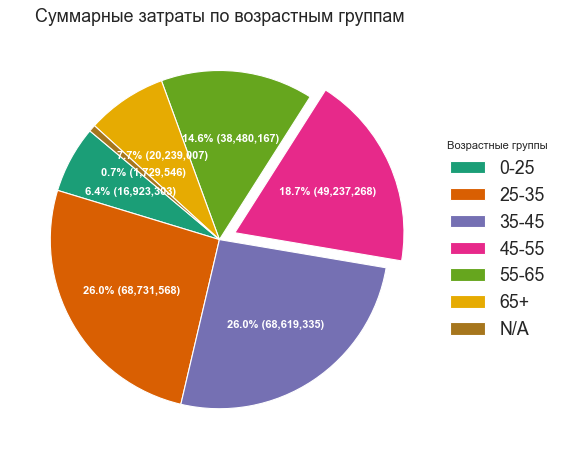

In [33]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df_pie_total['Total_amount']
categories = df_pie_total['Age_group']
explode = [0,0,0,0.1,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:,})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),textprops=dict(color="w"), 
colors=plt.cm.Dark2.colors, startangle=140, explode=explode)
ax.legend(wedges, categories, title="Возрастные группы", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Суммарные затраты по возрастным группам")
plt.show()

In [34]:
df_pie_pivot = pd.pivot_table(df_pie, columns='Age_group').reset_index()
df_pie_pivot

Age_group,index,0-25,25-35,35-45,45-55,55-65,65+,N/A
0,Cat_babyprod_amount,996769,4323105,4158571,2840425,1988406,928065,103202
1,Cat_careproducts_amount,5652386,24084105,22537943,15840999,12436642,6729952,574041
2,Cat_healthwellnes_amount,1291715,5578484,5430561,3708615,2619331,1229857,110708
3,Cat_householdchem_amount,3889624,15198910,15541674,11411195,9444205,4985821,395268
4,Cat_toiletries_amount,5092807,19546958,20950583,15436037,11991581,6365311,546326
5,Total_amount,16923303,68731564,68619333,49237273,38480167,20239008,1729547
